In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

In [7]:
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

ENV = 'CartPole-v0'  # 使用する課題名
GAMMA = 0.99  # 時間割引率
MAX_STEPS = 200  # 1試行のstep数
NUM_EPISODES = 500  # 最大試行回数

In [14]:
class ReplayMemory:

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # メモリの最大長さ
        self.memory = []  # 経験を保存する変数
        self.index = 0  # 保存するindexを示す変数

    def push(self, state, action, state_next, reward):
        '''transition = (state, action, state_next, reward)をメモリに保存する'''

        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリが満タンでないときは足す

        # namedtupleのTransitionを使用し、値とフィールド名をペアにして保存します
        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # 保存するindexを1つずらす

    def sample(self, batch_size):
        '''batch_size分だけ、ランダムに保存内容を取り出す'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''関数lenに対して、現在の変数memoryの長さを返す'''
        return len(self.memory)


In [42]:
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得

        # 経験を記憶するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)

        # ニューラルネットワークを構築
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)  # ネットワークの形を出力

        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):
        '''Experience Replayでネットワークの結合パラメータを学習'''

        # -----------------------------------------
        # 1. メモリサイズの確認
        # -----------------------------------------
        # 1.1 メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return

        # -----------------------------------------
        # 2. ミニバッチの作成
        # -----------------------------------------
        # 2.1 メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 各変数をミニバッチに対応する形に変形
        # transitionsは1stepごとの(state, action, state_next, reward)が、BATCH_SIZE分格納されている
        # つまり、(state, action, state_next, reward)×BATCH_SIZE
        # これをミニバッチにしたい。つまり
        # (state×BATCH_SIZE, action×BATCH_SIZE, state_next×BATCH_SIZE, reward×BATCH_SIZE)にする
        batch = Transition(*zip(*transitions))

        # 2.3 各変数の要素をミニバッチに対応する形に変形し、ネットワークで扱えるようVariableにする
        # 例えばstateの場合、[torch.FloatTensor of size 1x4]がBATCH_SIZE分並んでいるのですが、
        # それを torch.FloatTensor of size BATCH_SIZEx4 に変換します
        # 状態、行動、報酬、non_finalの状態のミニバッチのVariableを作成
        # catはConcatenates（結合）のことです。
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        # -----------------------------------------
        # 3. 教師信号となるQ(s_t, a_t)値を求める
        # -----------------------------------------
        # 3.1 ネットワークを推論モードに切り替える
        self.model.eval()

        # 3.2 ネットワークが出力したQ(s_t, a_t)を求める
        # self.model(state_batch)は、右左の両方のQ値を出力しており
        # [torch.FloatTensor of size BATCH_SIZEx2]になっている。
        # ここから実行したアクションa_tに対応するQ値を求めるため、action_batchで行った行動a_tが右か左かのindexを求め
        # それに対応するQ値をgatherでひっぱり出す。
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # 3.3 max{Q(s_t+1, a)}値を求める。ただし次の状態があるかに注意。

        # cartpoleがdoneになっておらず、next_stateがあるかをチェックするインデックスマスクを作成
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                    batch.next_state)))
        # まずは全部0にしておく
        next_state_values = torch.zeros(BATCH_SIZE)

        # 次の状態があるindexの最大Q値を求める
        # 出力にアクセスし、max(1)で列方向の最大値の[値、index]を求めます
        # そしてそのQ値（index=0）を出力します
        # detachでその値を取り出します
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()

        # 3.4 教師となるQ(s_t, a_t)値を、Q学習の式から求める
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        # -----------------------------------------
        # 4. 結合パラメータの更新
        # -----------------------------------------
        # 4.1 ネットワークを訓練モードに切り替える
        self.model.train()

        # 4.2 損失関数を計算する（smooth_l1_lossはHuberloss）
        # expected_state_action_valuesは
        # sizeが[minbatch]になっているので、unsqueezeで[minibatch x 1]へ
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))

        # 4.3 結合パラメータを更新する
        self.optimizer.zero_grad()  # 勾配をリセット
        loss.backward()  # バックプロパゲーションを計算
        self.optimizer.step()  # 結合パラメータを更新

    def decide_action(self, state, episode):
        '''現在の状態に応じて、行動を決定する'''
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()  # ネットワークを推論モードに切り替える
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # ネットワークの出力の最大値のindexを取り出します = max(1)[1]
            # .view(1,1)は[torch.LongTensor of size 1]　を size 1x1 に変換します

        else:
            # 0,1の行動をランダムに返す
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  # 0,1の行動をランダムに返す
            # actionは[torch.LongTensor of size 1x1]の形になります

        return action


In [43]:
class Agent:
    def __init__(self, num_states, num_actions):
        '''課題の状態と行動の数を設定する'''
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための頭脳を生成

    def update_q_function(self):
        '''Q関数を更新する'''
        self.brain.replay()

    def get_action(self, state, episode):
        '''行動を決定する'''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        self.brain.memory.push(state, action, state_next, reward)


In [44]:
class Environment:

    def __init__(self):
        self.env = gym.make(ENV, render_mode='rgb_array')  # 実行する課題を設定
        num_states = self.env.observation_space.shape[0]  # 課題の状態数4を取得
        num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        self.agent = Agent(num_states, num_actions)  # 環境内で行動するAgentを生成
        self.frames = []
        
    def run(self):
        '''実行'''
        episode_10_list = np.zeros(10)  # 10試行分の立ち続けたstep数を格納し、平均ステップ数を出力に利用
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        episode_final = False  # 最後の試行フラグ

        for episode in range(NUM_EPISODES):  # 最大試行数分繰り返す
            observation = self.env.reset()[0]  # 環境の初期化

            state = observation  # 観測をそのまま状態sとして使用
            state = torch.from_numpy(state).type(torch.FloatTensor)  # NumPy変数をPyTorchのテンソルに変換
            state = torch.unsqueeze(state, 0)  # size 4をsize 1x4に変換

            for step in range(MAX_STEPS):  # 1エピソードのループ

                if episode_final is True:  # 最終試行ではframesに各時刻の画像を追加していく
                    self.frames.append(self.env.render())

                action = self.agent.get_action(state, episode)  # 行動を求める

                # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
                # actionから.item()を指定して、中身を取り出す
                observation_next, _, terminated, truncated, info = self.env.step(action.item())  # rewardとinfoは使わないので_にする
                done = terminated or truncated

                # 報酬を与える。さらにepisodeの終了評価と、state_nextを設定する
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    state_next = None  # 次の状態はないので、Noneを格納

                    # 直近10episodeの立てたstep数リストに追加
                    episode_10_list = np.hstack((episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor([-1.0])  # 途中でこけたら罰則として報酬-1を与える
                        complete_episodes = 0  # 連続成功記録をリセット
                    else:
                        reward = torch.FloatTensor([1.0])  # 立ったまま終了時は報酬1を与える
                        complete_episodes = complete_episodes + 1  # 連続記録を更新
                else:
                    reward = torch.FloatTensor([0.0])  # 普段は報酬0
                    state_next = observation_next  # 観測をそのまま状態とする
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # numpy変数をPyTorchのテンソルに変換
                    state_next = torch.unsqueeze(state_next, 0)  # size 4をsize 1x4に変換

                # メモリに経験を追加
                self.agent.memorize(state, action, state_next, reward)

                # Experience ReplayでQ関数を更新する
                self.agent.update_q_function()

                # 観測の更新
                state = state_next

                # 終了時の処理
                if done:
                    # print('%d Episode: Finished after %d steps：10試行の平均step数 = %.1lf' % (episode, step + 1, episode_10_list.mean()))
                    break

            if episode_final is True:
                # 動画を保存と描画
                # display_frames_as_gif(frames)
                break

            # 10連続で200step経ち続けたら成功
            if complete_episodes >= 10:
                print('10回連続成功')
                episode_final = True  # 次の試行を描画を行う最終試行とする


In [45]:
cartpole_env = Environment()
cartpole_env.run()

Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
Transition(state=(tensor([[ 3.2054e-02,  1.1403e+00, -1.3255e-03, -1.5334e+00]]), tensor([[-0.0483,  0.0373, -0.0056,  0.0076]]), tensor([[ 0.0966,  1.3365, -0.0877, -1.8535]]), tensor([[-0.0502,  0.4271,  0.0072, -0.5686]]), tensor([[-0.0236,  0.1685,  0.0685, -0.1535]]), tensor([[-0.0524, -0.1578,  0.0067,  0.2993]]), tensor([[ 0.0131,  0.9455,  0.0236, -1.2482]]), tensor([[-0.0182, -0.0240,  0.0567,  0.0814]]), tensor([[ 0.1540,  1.7286, -0.1682, -2.5006]]), tensor([[-0.0008, -0.0219,  0.0293,  0.0352]]), tensor([[-0.0292,  0.8173, -0.0213, -1.1529]]), tensor([[-0.0056, -0.4130,  0.0367,  0.6390]]), tensor([[-0.0019,  0.7510,  0.0430, -0.9694]]), tensor([[-0.0555,  0.0373,  0.0127,  0.0087]]), tensor([[-0.0416,  0.6222, -0.0041, -0.8590]]), tensor([[-0.0507, 

/tmp/ipykernel_151941/3986072621.py:91: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:27.)
  next_state_values[non_final_mask] = self.model(


Transition(state=(tensor([[-0.0130,  0.5567,  0.0569, -0.6951]]), tensor([[-0.0531,  0.0374,  0.0066,  0.0045]]), tensor([[-0.0459,  0.0370, -0.0119,  0.0150]]), tensor([[-0.0555,  0.0373,  0.0127,  0.0087]]), tensor([[ 0.1540,  1.7286, -0.1682, -2.5006]]), tensor([[ 0.0549,  0.9452, -0.0320, -1.2412]]), tensor([[-0.0476, -0.1577, -0.0054,  0.2985]]), tensor([[ 0.0966,  1.3365, -0.0877, -1.8535]]), tensor([[ 0.0519,  1.2104, -0.1384, -1.8140]]), tensor([[-0.0292,  0.8173, -0.0213, -1.1529]]), tensor([[-0.0221,  0.2186,  0.0096, -0.2915]]), tensor([[ 0.1233,  1.5325, -0.1248, -2.1721]]), tensor([[-0.0182, -0.0240,  0.0567,  0.0814]]), tensor([[-0.0056, -0.4130,  0.0367,  0.6390]]), tensor([[-0.0502,  0.4271,  0.0072, -0.5686]]), tensor([[-0.0177,  0.4135,  0.0037, -0.5812]]), tensor([[ 0.0761,  1.4068, -0.1747, -2.1463]]), tensor([[-0.0500, -0.1577,  0.0007,  0.2970]]), tensor([[-0.0013, -0.2174,  0.0300,  0.3370]]), tensor([[ 0.0027,  0.8038, -0.0253, -1.1678]]), tensor([[-0.0452, -0.1

KeyboardInterrupt: 

gifを保存します


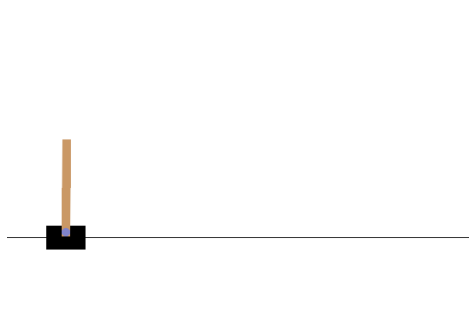

In [37]:
from matplotlib import animation
def save_gif(frames):
    fig = plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    ax = fig.add_subplot()
    ax.axis('off')
    output_frames = [[plt.imshow(f)] for f in frames]
    anim = animation.ArtistAnimation(fig, output_frames, interval=50, repeat=False)
    anim.save("animation.gif", writer="pillow")

if not cartpole_env.frames:
    print("学習がおわりませんでした")
else:
    print("gifを保存します")
    save_gif(cartpole_env.frames)
    
# save_gif(cartpole_env.frames)